# Patient Survival Prediction

**Description**: Getting a rapid understanding of the context of a patient’s overall health has been particularly important during the COVID-19 pandemic as healthcare workers around the world struggle with hospitals overloaded by patients in critical condition. Intensive Care Units (ICUs) often lack verified medical histories for incoming patients. A patient in distress or a patient who is brought in confused or unresponsive may not be able to provide information about chronic conditions such as heart disease, injuries, or diabetes. Medical records may take days to transfer, especially for a patient from another medical provider or system. Knowledge about chronic conditions can inform clinical decisions about patient care and ultimately improve patient's survival outcomes.

**Problem Statement**: The task is to classify hospital death based on the other 84 features step-by-step by going through each day's task. The scoring metric is *Accuracy/Area under ROC curve*.

## Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
!pip install omnixai dash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.9 MB 5.2 MB/s 
     |████████████████████████████████| 357 kB 1.3 MB/s 


In [2]:
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 5.1 MB/s 
     |████████████████████████████████| 1.6 MB 52.3 MB/s 


In [3]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.1 MB/s 


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
sns.set()


import plotly.express as px
import plotly.offline as py
import plotly.graph_objects as go
import plotly.tools as tls
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

import keras_tuner as kt

from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,roc_auc_score,precision_recall_curve,roc_curve

import shap

from omnixai.data.tabular import Tabular
from omnixai.preprocessing.tabular import TabularTransform
from omnixai.explainers.tabular import TabularExplainer

## Importing Data

In [5]:
dataset=pd.read_csv("/content/drive/MyDrive/Patient Survival Detection/Dataset/Dataset.csv")
dictionary=pd.read_csv("/content/drive/MyDrive/Patient Survival Detection/Dataset/Data Dictionary.csv")

In [6]:
dataset.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [7]:
dictionary

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
0,identifier,encounter_id,None,integer,Unique identifier associated with a patient un...,None
1,identifier,hospital_id,None,integer,Unique identifier associated with a hospital,None
2,identifier,patient_id,None,integer,Unique identifier associated with a patient,None
3,demographic,hospital_death,None,binary,Whether the patient died during this hospitali...,0
4,demographic,age,Years,numeric,The age of the patient on unit admission,None
...,...,...,...,...,...,...
183,APACHE comorbidity,lymphoma,None,binary,Whether the patient has been diagnosed with no...,1
184,APACHE comorbidity,solid_tumor_with_metastasis,None,binary,Whether the patient has been diagnosed with an...,1
185,APACHE grouping,apache_3j_bodysystem,None,string,Admission diagnosis group for APACHE III,Cardiovascular
186,APACHE grouping,apache_2_bodysystem,None,string,Admission diagnosis group for APACHE II,Respiratory


### EDA

In [9]:
dataset.shape

(91713, 186)

In [10]:
dataset.info(verbose=True,null_counts=True)

null_counts is deprecated. Use show_counts instead


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 186 columns):
 #    Column                         Non-Null Count  Dtype  
---   ------                         --------------  -----  
 0    encounter_id                   91713 non-null  int64  
 1    patient_id                     91713 non-null  int64  
 2    hospital_id                    91713 non-null  int64  
 3    hospital_death                 91713 non-null  int64  
 4    age                            87485 non-null  float64
 5    bmi                            88284 non-null  float64
 6    elective_surgery               91713 non-null  int64  
 7    ethnicity                      90318 non-null  object 
 8    gender                         91688 non-null  object 
 9    height                         90379 non-null  float64
 10   hospital_admit_source          70304 non-null  object 
 11   icu_admit_source               91601 non-null  object 
 12   icu_id                        

In [11]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
encounter_id,91713.0,65606.079280,37795.088538,1.0,32852.0,65665.0,98342.0,131051.0
patient_id,91713.0,65537.131464,37811.252183,1.0,32830.0,65413.0,98298.0,131051.0
hospital_id,91713.0,105.669262,62.854406,2.0,47.0,109.0,161.0,204.0
hospital_death,91713.0,0.086302,0.280811,0.0,0.0,0.0,0.0,1.0
age,87485.0,62.309516,16.775119,16.0,52.0,65.0,75.0,89.0
...,...,...,...,...,...,...,...,...
hepatic_failure,90998.0,0.012989,0.113229,0.0,0.0,0.0,0.0,1.0
immunosuppression,90998.0,0.026165,0.159628,0.0,0.0,0.0,0.0,1.0
leukemia,90998.0,0.007066,0.083763,0.0,0.0,0.0,0.0,1.0
lymphoma,90998.0,0.004132,0.064148,0.0,0.0,0.0,0.0,1.0


**Observation**:-

**Age**

Min:- 16years and Max:- 89years

**BMI**

Min:- 14.84 and Max:- 67.81

**Weight**

Min:- 38.6kg and Max:- 186kg

columns that can be dropped: 'encounter_id', 'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'patient_id', 'hospital_id', 'readmission_status'

In [12]:
pd.DataFrame(dataset.isna().sum(axis=0).sort_values(ascending=False).T,columns=["Value"])

,Value
h1_bilirubin_min,84619
h1_bilirubin_max,84619
h1_lactate_max,84369
h1_lactate_min,84369
h1_albumin_max,83824
...,...
icu_type,0
pre_icu_los_days,0
readmission_status,0
apache_post_operative,0


Let's put threshold of null values.Let it be 30K. Lets drop all such columns with above mentioned columns.

In [13]:
#Getting the columns name with more than 20K null values
missing=dataset.isnull().sum(axis=0).sort_values(ascending=False)[dataset.isnull().sum(axis=0).sort_values(ascending=False) > 30000]
dataset.drop(missing.index.tolist()+['encounter_id', 'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'patient_id', 'hospital_id', 'readmission_status'],
                     axis=1,
                     inplace=True)

dataset

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,icu_type,pre_icu_los_days,weight,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,0,68.0,22.730000,0,Caucasian,M,180.3,CTICU,0.541667,73.9,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,0,77.0,27.420000,0,Caucasian,F,160.0,Med-Surg ICU,0.927778,70.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,0,25.0,31.950000,0,Caucasian,F,172.7,Med-Surg ICU,0.000694,95.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,0,81.0,22.640000,1,Caucasian,F,165.1,CTICU,0.000694,61.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,0,19.0,NaN,0,Caucasian,M,188.0,Med-Surg ICU,0.073611,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,0,75.0,23.060250,0,Caucasian,M,177.8,Cardiac ICU,0.298611,72.9,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular
91709,0,56.0,47.179671,0,Caucasian,F,183.0,Med-Surg ICU,0.120139,158.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
91710,0,48.0,27.236914,0,Caucasian,M,170.2,Med-Surg ICU,0.046528,78.9,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
91711,0,NaN,23.297481,0,Caucasian,F,154.9,Med-Surg ICU,0.081944,55.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory


In [14]:
pd.DataFrame(dataset.nunique())

,0
hospital_death,2
age,74
bmi,34888
elective_surgery,2
ethnicity,6
...,...
leukemia,2
lymphoma,2
solid_tumor_with_metastasis,2
apache_3j_bodysystem,11


In [15]:
dataset = dataset[dataset[['bmi', 'weight', 'height']].isna().sum(axis=1) == 0]
dataset

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,icu_type,pre_icu_los_days,weight,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,0,68.0,22.730000,0,Caucasian,M,180.3,CTICU,0.541667,73.9,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,0,77.0,27.420000,0,Caucasian,F,160.0,Med-Surg ICU,0.927778,70.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,0,25.0,31.950000,0,Caucasian,F,172.7,Med-Surg ICU,0.000694,95.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,0,81.0,22.640000,1,Caucasian,F,165.1,CTICU,0.000694,61.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
5,0,67.0,27.560000,0,Caucasian,M,190.5,Med-Surg ICU,0.000694,100.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,0,75.0,23.060250,0,Caucasian,M,177.8,Cardiac ICU,0.298611,72.9,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular
91709,0,56.0,47.179671,0,Caucasian,F,183.0,Med-Surg ICU,0.120139,158.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
91710,0,48.0,27.236914,0,Caucasian,M,170.2,Med-Surg ICU,0.046528,78.9,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
91711,0,NaN,23.297481,0,Caucasian,F,154.9,Med-Surg ICU,0.081944,55.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory


### Univariate-Multivariate Analysis

In [15]:
fig = px.histogram(dataset[['age','gender','hospital_death','bmi']].dropna(), x="age", y="hospital_death", color="gender",
                   marginal="box", # or violin, rug
                   hover_data=dataset[['age','gender','hospital_death','bmi']].columns)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

Observation:-

Male:-

* Max Age:- 89 and deaths:-72
* Min Age:- 17 and deaths:-1
* Highest Death is of age:-80 with total death:-122

Female:-

* Max Age:-89 and death:- 66
* Min Age:- 16 and death:- 1
* Highest Death is of age:-83 with total death:-110


In [16]:
age_death_F=dataset[dataset['gender']=='F'][['age','hospital_death']].groupby('age').mean().reset_index()
age_death_M=dataset[dataset['gender']=='M'][['age','hospital_death']].groupby('age').mean().reset_index()
fig = make_subplots()
fig.add_trace(
    go.Scatter(x=age_death_F['age'], y=age_death_F['hospital_death'], name="Female patients"))
fig.add_trace(
    go.Scatter(x=age_death_M['age'], y=age_death_M['hospital_death'],name="Male patients"))
fig.update_layout(
    title_text="<b>Average hospital death probability of patients<b>")
fig.update_xaxes(title_text="<b>patient age<b>")
fig.update_yaxes(title_text="<b>Average Hospital Death</b>", secondary_y=False)
fig.show()

Observation:-
* Average hospital deaths is increasing with the increase in Patient Age for both Male and Female.
* There is no regular trend that Male has more average hospital death than female over the full course of patient age.

In [17]:
weight_df=dataset[['weight','hospital_death','bmi']]
weight_df['weight']=weight_df['weight'].round(0)
weight_df['bmi']=weight_df['bmi'].round(0)
weight_death=weight_df[['weight','hospital_death']].groupby('weight').mean().reset_index()
bmi_death=weight_df[['bmi','hospital_death']].groupby('bmi').mean().reset_index()
fig = make_subplots(rows=1, cols=2, shared_yaxes=True)
fig.add_trace(
    go.Scatter(x=weight_death['weight'], y=weight_death['hospital_death'], name="Weight"),
   row=1, col=1
)
fig.add_trace(
    go.Scatter(x=bmi_death['bmi'], y=bmi_death['hospital_death'], name="BMI"),
    row=1, col=2
)
fig.update_layout(
    title_text="<b>impacts of BMI and weight over patients<b>"
)
fig.update_yaxes(title_text="<b>Average Hospital Death")
fig.show();

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Observation:- 

Weight:-
* Highest Average Hospital Death is at 162kg.
* After the weight of 157kg the average hospital death trend has increased tremendously.

BMI:-
* Highest Average Hospital Death is at BMI of  65.
* There is more average hospital death for low as well as high BMI.

In [18]:
ICU_type=dataset[['icu_type','age','hospital_death']]
#ICU_type['pre_icu_los_days']=ICU_type['pre_icu_los_days'].round(0)
ICU_df=ICU_type.groupby(['icu_type','age']).mean().reset_index()
ICU_df['count']=ICU_type.groupby(['icu_type','age']).count().reset_index()['hospital_death']

fig = px.scatter(ICU_df, x="age", y="hospital_death", size="count", color="icu_type", hover_name="icu_type", log_x=False, size_max=60,)
fig.update_layout(title_text="<b>Survival rate at different types of ICU<b>")
fig.update_yaxes(title_text="<b>Average Hospital Death<b>")
fig.update_xaxes(title_text="<b>Age<b>")
fig.show()

Observation

* We can see that "Med-Surg ICU" has more number of counts for every age person.With increase in age the number of deaths increases in this "Med-Surg ICU"
* Highest number of death occurs for "MICU" patient for almost every age.
* "CSICU" has lowest average hospital death for almost every age.

In [19]:
apache3=dataset[['age','apache_3j_bodysystem','hospital_death']]
apache3=apache3.groupby(['apache_3j_bodysystem','age']).agg(['size','mean']).reset_index()

apache3['size']=apache3['hospital_death']['size']
apache3['mean']=apache3['hospital_death']['mean']

apache3.drop('hospital_death',axis=1,inplace=True)

systems =list(apache3['apache_3j_bodysystem'].unique())
data = []
list_updatemenus = []
for n, s in enumerate(systems):
    visible = [False] * len(systems)
    visible[n] = True
    temp_dict = dict(label = str(s),
                 method = 'update',
                 args = [{'visible': visible},
                         {'title': '<b>'+s+'<b>'}])
    list_updatemenus.append(temp_dict)
    

for s in systems:
    mask = (apache3['apache_3j_bodysystem'].values == s) 
    trace = (dict(visible = False,     
        x = apache3.loc[mask, 'age'],
        y = apache3.loc[mask, 'mean'],
        mode = 'markers',
        marker = {'size':apache3.loc[mask, 'size']/apache3.loc[mask,'size'].sum()*1000,
                 'color':apache3.loc[mask, 'mean'],
                 'showscale': True})
                   )
    data.append(trace)

data[0]['visible'] = True    
    
layout = dict(updatemenus=list([dict(buttons= list_updatemenus)]),
              xaxis=dict(title = '<b>Age<b>', range=[min(apache3.loc[:, 'age'])-10, max(apache3.loc[:, 'age']) + 10]),
              yaxis=dict(title = '<b>Average Hospital Death<b>', range=[min(apache3.loc[:, 'mean'])-0.1, max(apache3.loc[:, 'mean'])+0.1]),
              title='<b>Survival Rate<b>' )
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='update_dropdown')

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:4150: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



Observation:- 

Cardiovascular:-
* Maximum average hospital death occur for age 84.

Gastrointestinal:- 
* Maximum average hospital death  occur for age 80 and 89.

Genitourinary:- 
* Follows random trend but average hospital deaths occur for 86 and 79.

Gynecological:- 
* Most age people have average hospital death 0.

Hematological:- 
* Random fashion is observed and maximum hospital deaths occur for 64.

Metabolic:-
* Follows linear trend along average hospital death=0 and it has maximum death at age of 86.

Muscluoskeletal/Skin:-
* For below age 50 average hospital death is 0 and maximum occur at age of 87 and 82.

Neurlogical:-
* Somewhat increasing sequence is observed and maximum average hospital death occur at age of 87.

Respiratory:-
* Maximum hospital deaths occur at 80 and 85.

Sepsis:-
* Almost all age have above 0 average hospital deaths and maximum occur at the age of 83 and 86.

Trauma:-
* Many age have similar average deaths.

In [20]:
apache3=dataset[['age','apache_2_bodysystem','hospital_death']]
apache3=apache3.groupby(['apache_2_bodysystem','age']).agg(['size','mean']).reset_index()

apache3['size']=apache3['hospital_death']['size']
apache3['mean']=apache3['hospital_death']['mean']

apache3.drop('hospital_death',axis=1,inplace=True)

systems =list(apache3['apache_2_bodysystem'].unique())
data = []
list_updatemenus = []
for n, s in enumerate(systems):
    visible = [False] * len(systems)
    visible[n] = True
    temp_dict = dict(label = str(s),
                 method = 'update',
                 args = [{'visible': visible},
                         {'title': '<b>'+s+'<b>'}])
    list_updatemenus.append(temp_dict)
    

for s in systems:
    mask = (apache3['apache_2_bodysystem'].values == s) 
    trace = (dict(visible = False,     
        x = apache3.loc[mask, 'age'],
        y = apache3.loc[mask, 'mean'],
        mode = 'markers',
        marker = {'size':apache3.loc[mask, 'size']/apache3.loc[mask,'size'].sum()*1000,
                 'color':apache3.loc[mask, 'mean'],
                 'showscale': True})
                   )
    data.append(trace)

data[0]['visible'] = True    
    
layout = dict(updatemenus=list([dict(buttons= list_updatemenus)]),
              xaxis=dict(title = '<b>Age<b>', range=[min(apache3.loc[:, 'age'])-10, max(apache3.loc[:, 'age']) + 10]),
              yaxis=dict(title = '<b>Average Hospital Death<b>', range=[min(apache3.loc[:, 'mean'])-0.1, max(apache3.loc[:, 'mean'])+0.1]),
              title='<b>Survival Rate<b>' )
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='update_dropdown')

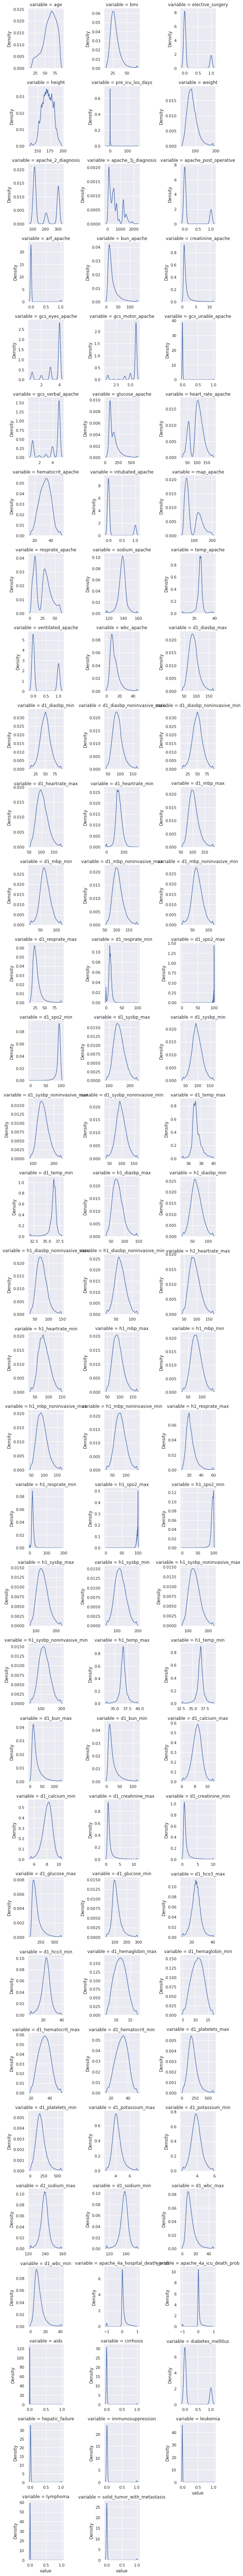

In [21]:
unpivot = pd.melt(dataset, dataset.describe().columns[0], dataset.describe().columns[1:])

g = sns.FacetGrid(unpivot, col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.kdeplot, "value")

plt.show()

Observation:-

Many features exhibit the property of normal distribution.

## Preprocessing

In [16]:
number_columns=dataset.select_dtypes(include=np.number).columns
number_columns

Index(['hospital_death', 'age', 'bmi', 'elective_surgery', 'height',
       'pre_icu_los_days', 'weight', 'apache_2_diagnosis',
       'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache',
       'bun_apache', 'creatinine_apache', 'gcs_eyes_apache',
       'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache',
       'glucose_apache', 'heart_rate_apache', 'hematocrit_apache',
       'intubated_apache', 'map_apache', 'resprate_apache', 'sodium_apache',
       'temp_apache', 'ventilated_apache', 'wbc_apache', 'd1_diasbp_max',
       'd1_diasbp_min', 'd1_diasbp_noninvasive_max',
       'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min',
       'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max',
       'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min',
       'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min',
       'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max',
       'd1_temp_min', 'h1_diasbp_max', 'h1_dias

In [17]:
len(number_columns)

99

In [18]:
categorical_columns=list(set(dataset.columns)-set(number_columns))
categorical_columns,len(categorical_columns)

(['apache_2_bodysystem',
  'icu_type',
  'ethnicity',
  'gender',
  'apache_3j_bodysystem'],
 5)

filling the null values of numerical columns with the mean of respective columns and categorical column with the mode.

In [19]:
#For the numerical columns
for cols in number_columns:
  mean=dataset[cols].mean()
  dataset[cols].fillna(value=mean,inplace=True)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
#For the categorical columns
for cols in categorical_columns:
  mode=dataset[cols].mode()[0]
  dataset[cols].fillna(value=mean,inplace=True)

In [21]:
dataset=pd.get_dummies(dataset,
    prefix='isin',
    prefix_sep='_',
    columns=categorical_columns,
    drop_first=False)
dataset.reset_index(drop = True, inplace = True)
dataset.head()

,hospital_death,age,bmi,elective_surgery,height,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,...,isin_Gastrointestinal,isin_Genitourinary,isin_Gynecological,isin_Hematological,isin_Metabolic,isin_Musculoskeletal/Skin,isin_Neurological,isin_Respiratory,isin_Sepsis,isin_Trauma
0,0,68.0,22.73,0,180.3,0.541667,73.9,113.0,502.01,0,...,0,0,0,0,0,0,0,0,1,0
1,0,77.0,27.42,0,160.0,0.927778,70.2,108.0,203.01,0,...,0,0,0,0,0,0,0,1,0,0
2,0,25.0,31.95,0,172.7,0.000694,95.3,122.0,703.03,0,...,0,0,0,0,1,0,0,0,0,0
3,0,81.0,22.64,1,165.1,0.000694,61.7,203.0,1206.03,1,...,0,0,0,0,0,0,0,0,0,0
4,0,67.0,27.56,0,190.5,0.000694,100.0,301.0,403.01,0,...,0,0,0,0,0,0,1,0,0,0


In [22]:
dataset.columns = [x.lower() for x in dataset.columns.tolist()]
dataset = dataset.loc[:,~dataset.columns.duplicated()]

## Neural Network

In [23]:
X=dataset.drop(['hospital_death'],axis=1)
y=dataset['hospital_death']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=11,stratify = y)

In [30]:
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(61798, 130) (26486, 130)
(61798,) (26486,)


In [31]:
model=tf.keras.Sequential([
    tf.keras.Input(130),
    tf.keras.layers.Dense(260,activation='relu'),
    tf.keras.layers.Dense(520,activation='relu'),
    tf.keras.layers.Dense(260,activation='relu'),
    tf.keras.layers.Dense(130,activation='relu'),
    tf.keras.layers.Dense(65,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 260)               34060     
                                                                 
 dense_1 (Dense)             (None, 520)               135720    
                                                                 
 dense_2 (Dense)             (None, 260)               135460    
                                                                 
 dense_3 (Dense)             (None, 130)               33930     
                                                                 
 dense_4 (Dense)             (None, 65)                8515      
                                                                 
 dense_5 (Dense)             (None, 1)                 66        
                                                                 
Total params: 347,751
Trainable params: 347,751
Non-trai

In [33]:
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001),
              metrics=["accuracy"])

In [34]:
history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=16,
                    epochs=20,
                    validation_data=(X_test,y_test))

Epoch 1/20
3863/3863 [==============================] - 23s 6ms/step - loss: 0.2990 - accuracy: 0.9059 - val_loss: 0.3311 - val_accuracy: 0.8710
Epoch 2/20
3863/3863 [==============================] - 26s 7ms/step - loss: 0.2562 - accuracy: 0.9133 - val_loss: 0.2420 - val_accuracy: 0.9184
Epoch 3/20
3863/3863 [==============================] - 24s 6ms/step - loss: 0.2455 - accuracy: 0.9157 - val_loss: 0.2360 - val_accuracy: 0.9187
Epoch 4/20
3863/3863 [==============================] - 22s 6ms/step - loss: 0.2408 - accuracy: 0.9163 - val_loss: 0.2363 - val_accuracy: 0.9185
Epoch 5/20
3863/3863 [==============================] - 24s 6ms/step - loss: 0.2372 - accuracy: 0.9182 - val_loss: 0.2399 - val_accuracy: 0.9181
Epoch 6/20
3863/3863 [==============================] - 24s 6ms/step - loss: 0.2353 - accuracy: 0.9176 - val_loss: 0.2315 - val_accuracy: 0.9189
Epoch 7/20
3863/3863 [==============================] - 24s 6ms/step - loss: 0.2324 - accuracy: 0.9185 - val_loss: 0.2303 - val_ac

In [35]:
def draw_graph(history=history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.figure()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

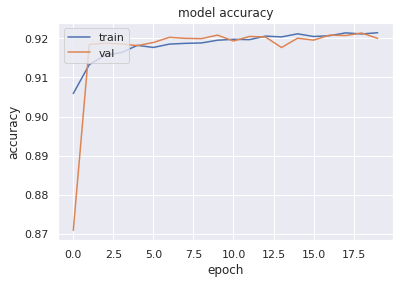

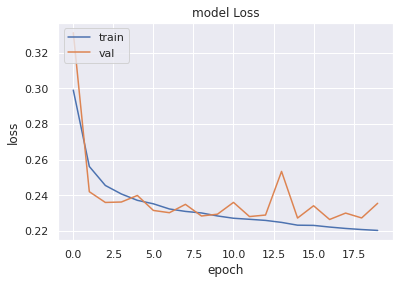

In [36]:
draw_graph(history=history)

### Hyperparameter Tuning for Neural Network

In [37]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model=tf.keras.Sequential([
            tf.keras.Input(130),
            tf.keras.layers.Dense(units=hp.Int("units", min_value=32, max_value=512, step=32),activation='relu'),
            tf.keras.layers.Dense(units=hp.Int("units", min_value=32, max_value=512, step=32),activation='relu'),
            tf.keras.layers.Dense(units=hp.Int("units", min_value=32, max_value=512, step=32),activation='relu'),
            tf.keras.layers.Dense(units=hp.Int("units", min_value=32, max_value=512, step=32),activation='relu'),
            tf.keras.layers.Dense(units=hp.Int("units", min_value=32, max_value=512, step=32),activation='relu'),
            tf.keras.layers.Dense(1,activation='sigmoid')
        ])
        
        hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
        model.compile(loss="binary_crossentropy",
                      optimizer=SGD(hp_learning_rate),
                      metrics = ['accuracy'])
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [16, 32]),
            **kwargs,
        )


tuner = kt.RandomSearch(MyHyperModel(),
                         objective="val_accuracy",
                         max_trials=15,
                         overwrite=True,
                         directory="my_dir",
                         project_name="NNmodel_hypermodel"
                         )

tuner.search(X_train, y_train, epochs = 50, validation_data = (X_test, y_test),callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)])

Trial 15 Complete [00h 04m 53s]
val_accuracy: 0.9197689294815063

Best val_accuracy So Far: 0.9223740696907043
Total elapsed time: 00h 54m 34s


In [38]:
# Which was the best model?
best_model_1 = tuner.get_best_models(1)[0]
print(best_model_1.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 448)               58688     
                                                                 
 dense_1 (Dense)             (None, 448)               201152    
                                                                 
 dense_2 (Dense)             (None, 448)               201152    
                                                                 
 dense_3 (Dense)             (None, 448)               201152    
                                                                 
 dense_4 (Dense)             (None, 448)               201152    
                                                                 
 dense_5 (Dense)             (None, 1)                 449       
                                                                 
Total params: 863,745
Trainable params: 863,745
Non-trai

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 260)               34060     
                                                                 
 dense_1 (Dense)             (None, 520)               135720    
                                                                 
 dense_2 (Dense)             (None, 260)               135460    
                                                                 
 dense_3 (Dense)             (None, 130)               33930     
                                                                 
 dense_4 (Dense)             (None, 65)                8515      
                                                                 
 dense_5 (Dense)             (None, 1)                 66        
                                                                 
Total params: 347,751
Trainable params: 347,751
Non-trai

We have reduced the number of trainable parameters but accuracy has not increased that much.

In [40]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Units:- {best_hps.get('units')}")
print(f"Best Learning Rate:- {best_hps.get('learning_rate')}")
print(f"Best Batch Size:- {best_hps.get('batch_size')}")

Best Units:- 448
Best Learning Rate:- 0.001
Best Batch Size:- 16


In [41]:
class MyHyperModel1(kt.HyperModel):
    def build(self, hp):
        model=Sequential()
        model.add(Input(130))
        for i in range(hp.Int("num_layers", 1, 6)):
          model.add(Dense(units=hp.Int(f"units_{i}", min_value=32, max_value=576, step=32),
                          activation=hp.Choice("activation", ["relu", "tanh"])))
        model.add(Dense(1,activation='sigmoid'))

        hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
        model.compile(loss="binary_crossentropy",
                      optimizer=SGD(hp_learning_rate),
                      metrics = ['accuracy'])
        
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [16, 32]),
            **kwargs,
        )
hp = kt.HyperParameters()
hypermodel = MyHyperModel1()
model = hypermodel.build(hp)
hypermodel.fit(hp, model, X_train,y_train)

tuner1 = kt.RandomSearch(MyHyperModel1(),
                         objective="val_accuracy",
                         max_trials=15,
                         overwrite=True,
                         directory="my_dir1",
                         project_name="NNmodel_hypermodel"
                         )
tuner1.search_space_summary()

3863/3863 [==============================] - 6s 2ms/step - loss: 0.8320 - accuracy: 0.9138
Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 576, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [42]:
tuner1.search(X_train, y_train, epochs = 50, validation_data = (X_test, y_test),callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)])

Trial 15 Complete [00h 00m 48s]
val_accuracy: 0.9144453406333923

Best val_accuracy So Far: 0.9210526347160339
Total elapsed time: 00h 39m 21s


In [43]:
tuner1.results_summary()

Results summary
Results in my_dir1/NNmodel_hypermodel
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 5
units_0: 224
activation: relu
learning_rate: 0.01
units_1: 320
units_2: 416
batch_size: 16
units_3: 320
units_4: 480
Score: 0.9210526347160339
Trial summary
Hyperparameters:
num_layers: 3
units_0: 480
activation: relu
learning_rate: 0.001
units_1: 32
units_2: 32
batch_size: 16
Score: 0.9205995798110962
Trial summary
Hyperparameters:
num_layers: 5
units_0: 128
activation: relu
learning_rate: 0.001
units_1: 448
units_2: 512
batch_size: 32
units_3: 224
units_4: 288
Score: 0.9189382791519165
Trial summary
Hyperparameters:
num_layers: 1
units_0: 128
activation: relu
learning_rate: 0.001
units_1: 352
units_2: 512
batch_size: 32
Score: 0.9179566502571106
Trial summary
Hyperparameters:
num_layers: 5
units_0: 256
activation: tanh
learning_rate: 0.001
units_1: 256
units_2: 544
batch_size: 32
units_3: 448
units_4: 448
Score: 0.9176546335220337
Trial summary
Hyperparameters:
nu

In [44]:
best_model_2 = tuner1.get_best_models(1)[0]
print(best_model_2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 224)               29344     
                                                                 
 dense_1 (Dense)             (None, 320)               72000     
                                                                 
 dense_2 (Dense)             (None, 416)               133536    
                                                                 
 dense_3 (Dense)             (None, 320)               133440    
                                                                 
 dense_4 (Dense)             (None, 480)               154080    
                                                                 
 dense_5 (Dense)             (None, 1)                 481       
                                                                 
Total params: 522,881
Trainable params: 522,881
Non-trai

In [45]:
best_model_2.evaluate(X_test,y_test)

828/828 [==============================] - 2s 3ms/step - loss: 0.2276 - accuracy: 0.9211


[0.22762945294380188, 0.9210526347160339]

In [46]:
best_model_1.evaluate(X_test,y_test)

828/828 [==============================] - 4s 4ms/step - loss: 0.2232 - accuracy: 0.9224


[0.22324413061141968, 0.9223740696907043]

In [47]:
best_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 448)               58688     
                                                                 
 dense_1 (Dense)             (None, 448)               201152    
                                                                 
 dense_2 (Dense)             (None, 448)               201152    
                                                                 
 dense_3 (Dense)             (None, 448)               201152    
                                                                 
 dense_4 (Dense)             (None, 448)               201152    
                                                                 
 dense_5 (Dense)             (None, 1)                 449       
                                                                 
Total params: 863,745
Trainable params: 863,745
Non-trai

Both model are giving same accuracy but the number of trainable parameters differs greatly.Therefore choosing second one.

In [48]:
def model_performance(model, y_test, y_hat) : 
    conf_matrix = confusion_matrix(y_test, y_hat)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                   y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto',
                   orientation = 'h', opacity = 0.8,marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
    
    #Roc curve
    model_roc_auc = round(roc_auc_score(y_test, y_hat) , 3)
    fpr, tpr, t = roc_curve(y_test, y_hat)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_hat)
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
     
    #plots
    model = model
    
    #Subplots
    fig = tls.make_subplots(rows=2, cols=2, print_grid=False, 
                          specs=[ 
#                               [{'colspan': 2}, None],
                                 [{}, {}],
                                 [{}, {}],
                                 
#                                  [{'colspan': 2}, None]
                                ],
                          subplot_titles=('Confusion Matrix',
                                        'Metrics',
                                        'ROC curve'+" "+ '('+ str(model_roc_auc)+')',
                                        'Precision - Recall curve',
                                        ))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report</b><br>'+str(model),
                        autosize = False, height = 1500,width = 830,
                        plot_bgcolor = 'rgba(240,240,240, 0.95)',
                        paper_bgcolor = 'rgba(240,240,240, 0.95)',
                        margin = dict(b = 195))
#     fig["layout"]["xaxis2"].update((dict(range=[0, 1])))
#     fig["layout"]["xaxis3"].update(dict(title = "false positive rate"))
#     fig["layout"]["yaxis3"].update(dict(title = "true positive rate"))
#     fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05])
#     fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05])
#     fig["layout"]["xaxis5"].update(dict(title = "Percentage contacted"))
#     fig["layout"]["yaxis5"].update(dict(title = "Percentage positive targeted"))
    fig.layout.titlefont.size = 14
    
    py.iplot(fig)

In [74]:
y_hat=model.predict(X_test)
for i in range(len(y_hat)):
  if(y_hat[i]<0.5):
    y_hat[i]=0
  else:
    y_hat[i]=1

y_hat=y_hat.astype('int64')

In [75]:
accuracy_score(y_test,y_hat)

0.9144453673638904

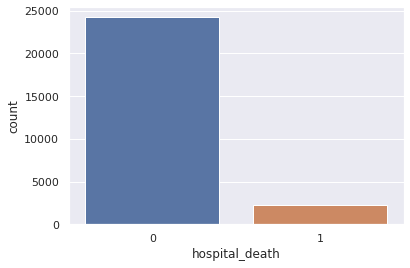

In [50]:
sns.countplot(x=y_test)

In [68]:
model_performance(best_model_2,y_test,y_hat)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



### Saving the model

In [52]:
best_model_2.save("/content/drive/MyDrive/Patient Survival Detection/Model/best_model_2")

In [8]:
modelF=tf.keras.models.load_model("/content/drive/MyDrive/Patient Survival Detection/Model/best_model_2")

## Explainable AI

In [24]:
shap.initjs()
explainer = shap.KernelExplainer(modelF, X_train.iloc[:50,:])
shap_values = explainer.shap_values(X_train.iloc[20,:], nsamples=500)

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


In [25]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_train.iloc[20,:])

In [28]:
shap.initjs()
shap_values50 = explainer.shap_values(X_train.iloc[50:100,:], nsamples=500)


  0%|          | 0/50 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [30]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values50[0], X_train.iloc[50:100,:])